# Running moscot

This notebook depends on data generated by 'MG_03-31-2022_Preprocessing_adata'

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)


import numpy as np
import anndata
import pandas as pd
import seaborn as sns
import scanpy as sc

import moscot
import scanpy as sc
from moscot.problems.time._lineage import TemporalProblem
from moscot.backends.ott._solver import SinkhornSolver

import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import ott
from ott.geometry import pointcloud
from ott.core import sinkhorn
from ott.tools import transport
import sklearn

import warnings
warnings.filterwarnings('ignore')

import datetime
import time
import os
sc.settings.verbosity = 0

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR']='platform'

In [2]:
Path="/home/icb/manuel.gander/Reproducibility_TOME/Data"
# Define time points
t=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[8.5]+[9.5+x for x in range(0,5)]
ts=[str(a) for a in [3.5, 4.5, 5.25, 5.5, 6.25]] + [str(a) for a in np.arange(6.5, 8.5, 0.25)] + ['8.5a', '8.5b']+ [str(a) for a in np.arange(9.5, 14.5, 1)]
ts=['E'+a for a in ts]

t2=[3.5, 4.5, 5.25, 5.5]+[6.25+x/4 for x in range(0,10)]+[9.5+x for x in range(0,5)]
cells=[32, 80, 100, 120, 400, 660, 1720, 4500, 8200, 15000, 30000, 60000, 73000, 90000, 200000, 1100000, 2600000, 6000000, 13000000 ]

av_g=np.ones(len(t2)-1)
for i in range(0,len(av_g)):
    av_g[i]=cells[i+1]/cells[i]/(t2[i+1]-t2[i])

In [3]:
def load_adata(ts0, ts1):
    # Load the adata
    
    A0=sc.read(f"{Path}/anndatas/adata_{ts0}.h5ad")
    A0.obs['stage']=ts0
    A1=sc.read(f"{Path}/anndatas/adata_{ts1}.h5ad")
    A1.obs['stage']=ts1
    
    adata=A0.concatenate(A1, join='outer', index_unique=None, batch_key=None)
    
    # Load the representation from Seurat-integration
    PCA=pd.read_csv(f"{Path}/Seurat_Representations/{ts0}_{ts1}_pca.csv", sep= ",")
    adata.obsm['X_pcaS']=PCA.to_numpy()[:,1:]
    adata.obsm['X_pcaS']=np.array(adata.obsm['X_pcaS'], dtype=np.float32)

    UMAP=pd.read_csv(f"{Path}/Seurat_Representations/{ts0}_{ts1}_umap3.csv", sep= ",")
    adata.obsm['X_umap3']=UMAP.to_numpy()[:,1:]
    adata.obsm['X_umap3']=np.array(adata.obsm['X_umap3'], dtype=np.float32)
    
    # Check if cells are ordered the same in adata as they are in the Seurat-representation, if not, reorder
    B=[a for a in PCA['Unnamed: 0']]
    A=[a for a in adata.obs_names]
    if A!=B:
        print('Reordering...')
        Dict={}
        for ii in range(0,len(A)):
            Dict[B[ii]]=ii
        PCA2=adata.obsm['X_pcaS'].copy()
        B2=B.copy()
        for ii in range(0,len(A)):
            PCA2[ii,:]=adata.obsm['X_pcaS'][Dict[A[ii]],:].copy()
            B2[ii]=B[Dict[A[ii]]]
        if A!=B2:
            print('Cell re-ordering was not succesful')
        else:
            adata.obsm['X_pcaS']=PCA2
            print('Done')
        
    A0=adata[adata.obs['stage']==ts0].copy()
    A1=adata[adata.obs['stage']==ts1].copy()
    A0.obs['arange']=np.arange(len(A0))
    A1.obs['arange']=np.arange(len(A1))

    return(A0, A1)

def give_lam1(i, eps):
    if i==0:
        lam1=1.5
    if i==1:
        lam1=3
    if i==2:
        lam1s=[2, 1]
        if eps>0.0002:
            lam1=lam1s[0]
        else:
            lam1=lam1s[1]

    if i==3:
        lam1=0.13
    if i==4:
        lam1s=[1.3, 0.17]
        if eps>0.0002:
            lam1=lam1s[0]
        elif eps==0.0001:
            lam1=0.4
        else:
            lam1=lam1s[1]
    if i==5:
        lam1=0.13
    if i==6:
        lam1s=[0.008, 0.004]
        if eps>0.000002:
            lam1=lam1s[0]
        else:
            lam1=lam1s[1]

    if i==7:
        lam1=0.02
    if i==8:
        lam1s=[0.1, 0.08, 0.03]
        if eps>0.0002:
            lam1=lam1s[0]
        elif eps==0.0001:
            lam1=lam1s[1]
        else:
            lam1=lam1s[2]

    if i==9:
        lam1s=[0.04, 0.02]
        if eps>0.00002:
            lam1=lam1s[0]
        else:
            lam1=lam1s[1]

    if i==10:
        lam1s=[0.6, 0.1, 0.03, 0.02]
        if eps>0.0002:
            lam1=lam1s[0]
        elif eps>0.00002:
            lam1=lam1s[1]
        elif eps==0.00001:
            lam1=lam1s[2]
        else:
            lam1=lam1s[3]
    if i==11:
        lam1s=[3, 0.5, 0.08, 0.05]
        if eps>0.0002:
            lam1=lam1s[0]
        elif eps>0.00002:
            lam1=lam1s[1]
        elif eps==0.00001:
            lam1=lam1s[2]
        else:
            lam1=lam1s[3]
    if i==12:
        lam1s=[0.3, 0.15, 0.04]
        if eps>0.0002:
            lam1=lam1s[0]
        elif eps==0.0001:
            lam1=lam1s[1]
        else:
            lam1=lam1s[2]

    if i ==13:
        lam1s=[0.05, 0.01, 0.005, 0.0005]
        if eps>0.00002:
            lam1=lam1s[0]
        elif eps==0.00001:
            lam1=lam1s[1]
        elif eps==0.000001:
            lam1=lam1s[2]
        else:
            lam1=lam1s[3]
            
    if i==14:
        lam1s=[0.05, 0.02, 0.015]
        if eps>0.00002:
            lam1=lam1s[0]
        elif eps==0.00001:
            lam1=lam1s[1]
        else:
            lam1=lam1s[2]
        
    if i==15:
        lam1s=[0.05, 0.03, 0.02]
        if eps>0.00002:
            lam1=lam1s[0]
        elif eps==0.00001:
            lam1=lam1s[1]
        else:
            lam1=lam1s[2]
            
            
    if i==16:
        lam1s=[0.035, 0.02, 0.02]
        if eps>0.00002:
            lam1=lam1s[0]
        elif eps==0.00001:
            lam1=lam1s[1]
        else:
            lam1=lam1s[2]
        
    if i==17:
        lam1s=[0.075, 0.035]
        if eps>0.00002:
            lam1=lam1s[0]
        else:
            lam1=lam1s[1]
    
    if i==18:
        lam1s=[0.05, 0.04, 0.035]
        if eps>0.00002:
            lam1=lam1s[0]
        elif eps==0.0001:
            lam1=lam1s[1]
        else:
            lam1=lam1s[2]
    
        
    return lam1

In [4]:
i=4
fraction=1


ts0=ts[i]
print('------------------------------------------------------------------------')
print(ts0)

ts1=ts[i+1]

(A0,  A1)=load_adata(ts0, ts1)
adata=A0.concatenate(A1, join='outer', index_unique=None, batch_key=None)
del adata.raw

# Prepare the gene annotation, which moscot uses to estimate proliferation/apoptosis scores
sc.pp.subsample(adata, fraction=fraction)

------------------------------------------------------------------------
E6.25
Reordering...
Done


In [6]:
adata.var['Ensembl']=adata.var_names
adata.var['index']=[str(a) for a in adata.var['gene_names']]
adata.var=adata.var.set_index('index')
adata.var_names_make_unique()

tp=TemporalProblem(adata)
tp.score_genes_for_marginals(gene_set_proliferation='mouse',  gene_set_apoptosis='mouse')
tp = tp.prepare('day', joint_attr='X_pcaS')

In [7]:
%%time
online=50000
eps=0.01

tp=TemporalProblem(adata)
tp.score_genes_for_marginals(gene_set_proliferation='mouse',  gene_set_apoptosis='mouse')
tp = tp.prepare('day', joint_attr='X_pcaS')


lam1=give_lam1(i,eps)
tau1=lam1/(lam1+eps)
tau2=tau1*0.01+0.99
print(eps)
print('Sinkhorn started...')
start = time.process_time()
tp.solve(online=online, epsilon=eps, tau_a=tau1, tau_b=tau2, scale_cost="mean")
tt=time.process_time() - start
print(tt)

0.01
Sinkhorn started...
30.090640682000014
CPU times: user 26.2 s, sys: 5.18 s, total: 31.4 s
Wall time: 30.8 s


Error: Solution for 6.25 to 6.5 did not converge
 Transitons calcualtion - Forward: 8.385165481000001
 Transitons calcualtion - Backward: 9.455090565999996
 Growths calcualtion - Backward: 1.4671065789999886
Percentage of apoptotic cells: 3.9298757217528464%


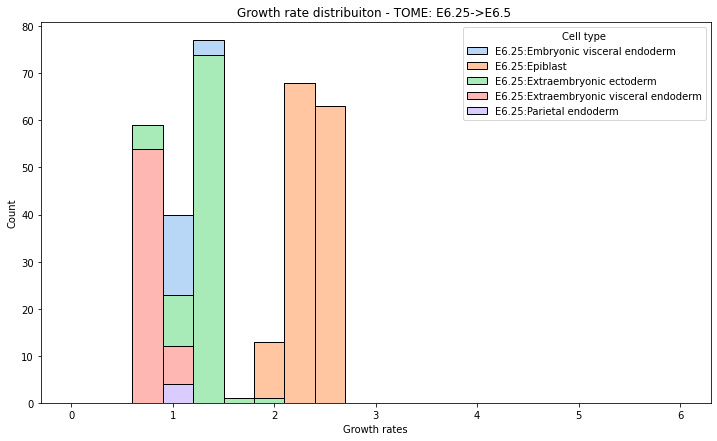

 Transitons calcualtion - Forward: 1.7709796950000225
Percentage of cells not hit: 0.1053570976375742%


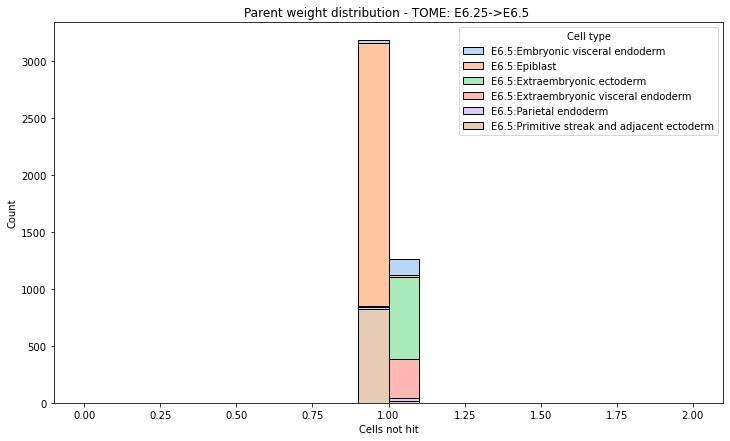

In [9]:
#  Check for convergence
if ts0=='E8.5a':
    t0=0
    t1=1
else:
    t0=t[i]
    t1=t[i+1]

if tp.solutions[(t0,t1)].converged:
    conv=1
else:
    print(f'Error: Solution for {t0} to {t1} did not converge')
    conv=0

###############################            Evaluation           #################################################

# Calculating transition rates between cell types
adata.obs['cell_state']=adata.obs['cell_state'].astype('category')
a0=adata[adata.obs['day']==t0].obs['cell_state'].cat.categories
a1=adata[adata.obs['day']==t1].obs['cell_state'].cat.categories


start = time.process_time()
# Forward-Evaluation
ct_desc= tp.cell_transition(early_cells={'cell_state': a0}, late_cells={'cell_state': a1}, start=t0, end=t1, forward=True)
t2=time.process_time() - start
print(f' Transitons calcualtion - Forward: {t2}')


A=anndata.AnnData(X=ct_desc.to_numpy().T)
A.var['cell_state_parent']=[a for a in ct_desc.index]
A.obs['cell_state_child']=[a for a in ct_desc.keys()]

start = time.process_time()
# Backward-Evaluation
ct_desc= tp.cell_transition(early_cells={'cell_state': a0}, late_cells={'cell_state': a1}, start=t0, end=t1, forward=False)
t2=time.process_time() - start
print(f' Transitons calcualtion - Backward: {t2}')
      
      
A2=anndata.AnnData(X=ct_desc.to_numpy().T)
A2.var['cell_state_parent']=[a for a in ct_desc.index]
A2.obs['cell_state_child']=[a for a in ct_desc.keys()]


# Calcualte growth rates
adata.obs['sample']=adata.obs['sample'].astype('category')
adata.obs['stage']=adata.obs['stage'].astype('category')
a=adata[adata.obs['stage']==ts[i]].obs['sample']
start = time.process_time()
ct_desc= tp.cell_transition(early_cells={'sample': a}, late_cells={'stage': [ts[i+1]]}, start=t0, end=t1, forward=False)
t2=time.process_time() - start
print(f' Growths calcualtion - Backward: {t2}')      
    
gs=np.array([a for a in ct_desc[ts[i+1]]])
if ts[i]=='E8.5a':
    gs=gs/gs.mean()
elif i>13:
    gs=gs/gs.mean()*av_g[i-1]*(t1-t0)
else:
    gs=gs/gs.mean()*av_g[i]*(t1-t0)
ap_w=0
for j in range(len(gs)):
    if gs[j]<1:
        ap_w+=1-gs[j]
ap_w=ap_w/len(gs)
print(f'Percentage of apoptotic cells: {ap_w*100}%')

Cst=adata[adata.obs['stage']==ts[i]].obs['cell_state']

df=pd.DataFrame({'growth_rates':gs, 'Cell type':Cst})
f = plt.figure(figsize=(12,7))
ax = f.add_subplot(1,1,1)

sns.histplot(data=df, ax=ax,  multiple="stack", x="growth_rates", hue='Cell type', bins=20, kde=False, binrange=[0,6], palette="pastel",legend=True)
ax.set_title(f"Growth rate distribuiton - TOME: {ts0}->{ts1} ")
ax.set_xlabel("Growth rates")
ax.set_ylabel("Count")

time.sleep(0.1)
plt.pause(0.0001) 


# Calculate late_marignal spread
a=adata[adata.obs['stage']==ts[i+1]].obs['sample']
start = time.process_time()
ct_desc= tp.cell_transition(early_cells={'stage': [ts[i]]}, late_cells={'sample': a}, start=t0, end=t1, forward=True)
t2=time.process_time() - start
print(f' Transitons calcualtion - Forward: {t2}')
gs=ct_desc.to_numpy()[0]
gs=gs/gs.mean()
ap_w=0
for j in range(len(gs)):
    if gs[j]<1:
        ap_w+=1-gs[j]
ap_w=ap_w/len(gs)
print(f'Percentage of cells not hit: {ap_w*100}%')

Cst=adata[adata.obs['stage']==ts1].obs['cell_state']

df=pd.DataFrame({'growth_rates':gs, 'Cell type':Cst})
f = plt.figure(figsize=(12,7))
ax = f.add_subplot(1,1,1)

sns.histplot(data=df, ax=ax,  multiple="stack", x="growth_rates", hue='Cell type', bins=20, kde=False, binrange=[0,2], palette="pastel",legend=True)
ax.set_title(f"Parent weight distribution - TOME: {ts0}->{ts1} ")
ax.set_xlabel("Cells not hit")
ax.set_ylabel("Count")

time.sleep(0.1)
plt.pause(0.0001) 